In [1]:
# %matplotlib widget
# Imports and setup
from pint import UnitRegistry
import math
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy

# Use pint
units = UnitRegistry()
units.default_format = "~P"
ureg = UnitRegistry()
ureg.setup_matplotlib()
Q_ = ureg.Quantity

## Lab 8

Q1: We verified that our duty cycle was about 30%, as expected due to our decreased output voltage to account for power limits on the clamp resistor.

Q2: The total power flowing into our converter was 17.28 W; the total flowing out was 13.45 W. This gives us an efficiency of 77.8%, with a total power loss of 3.83 W. 

In [2]:
### Baseline ###
Vg = 18 * units.volt
Ig = 0.96 * units.amp
Pin = (Vg * Ig).to('watt')
print("P_in:", Pin)
Vo = 8.3 * units.volt
Io = 1.62 * units.amp
Pout = (Vo * Io).to('watt')
print("P_out:", Pout)
print(f"Loss: {Pin - Pout} ({Pout/Pin * 100}%)")

P_in: 17.28 W
P_out: 13.446000000000002 W
Loss: 3.8339999999999996 W (77.8125%)


Q3: We made an error at this step and only recorded our final measurement at boundary conduction. Additionally, we were unable to increase the output voltage past 7.9 V.

Q4: The total power flowing into our converter was 16.61 W; the total power flowing out of our converter was 12.75 W. This gives us an efficiency of 76.8%, with a total power loss of 3.86 W.

In [3]:
### Reduced ###
Vg = 11 * units.volt
Ig = 1.51 * units.amp
Pin = (Vg * Ig).to('watt')
print("P_in:", Pin)
Vo = 7.97 * units.volt
Io = 1.6 * units.amp
Pout = (Vo * Io).to('watt')
print("P_out:", Pout)
print(f"Loss: {Pin - Pout} ({Pout/Pin * 100}%)")

P_in: 16.61 W
P_out: 12.752 W
Loss: 3.8579999999999988 W (76.77302829620712%)


Q5: Heat map, Overlay, Assembled Board

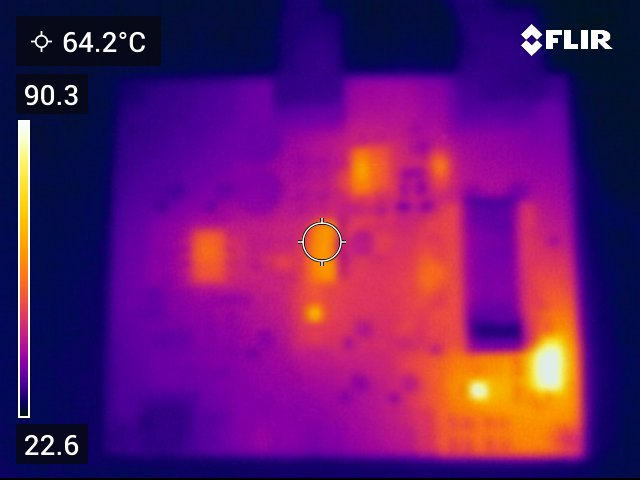 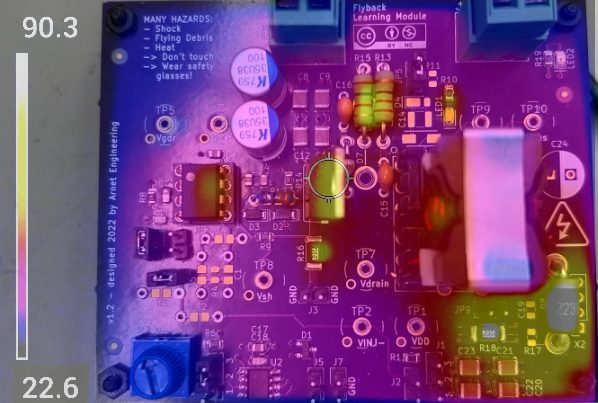 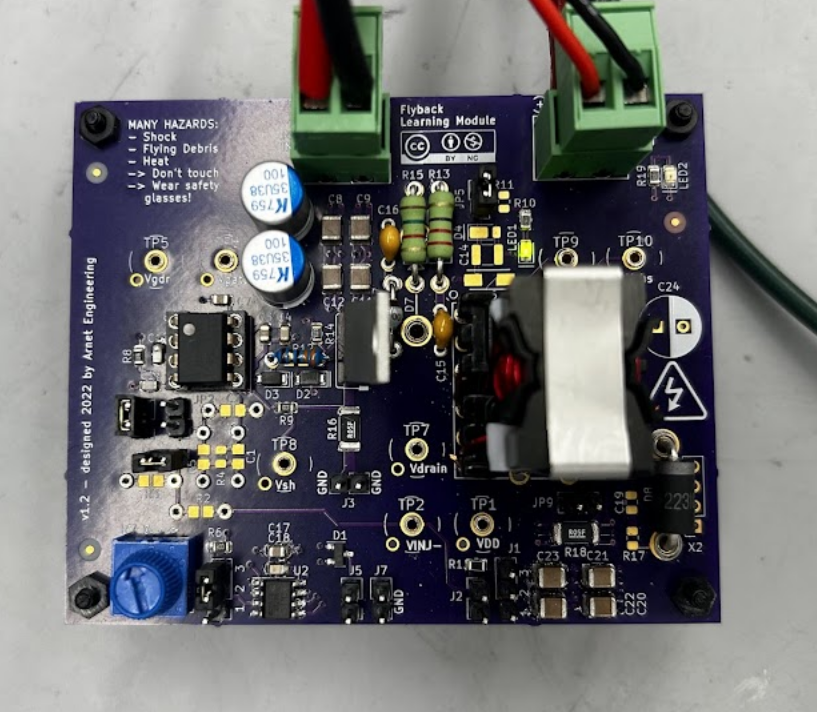

In [4]:
# Functions Used For Lab
def unpack_oscope(filepath): 
    data = pd.read_csv(filepath)
    increment = float(data["Increment"][0])
    data = data.iloc[1: , :]
    data = data.astype(float)
    data["time"] = data["X"] * increment
    return data

def plot_vsh_vdr(voltages, limits, offset):
    
    
    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)  
    for i, voltage in enumerate(voltages): 
        start_tick = limits[i][0]
        end_tick = limits[i][1]
        data = unpack_oscope(f"../data/{voltage}.csv")
        
        # Shunt voltage
        ax1.scatter(data["time"][start_tick:end_tick] + i*offset, 
                    data["CH1"][start_tick:end_tick], 
                    marker='.', s=0.5, label=voltage)
        # Drain Voltage
        ax2.scatter(data["time"][start_tick:end_tick] + i*offset, 
                    data["CH2"][start_tick:end_tick], 
                    marker='.', s=0.5, label=voltage)

        ax1.sharex(ax2)
        ax1.title.set_text("Shunt Voltage")
        ax2.title.set_text("Drain Voltage")
        ax2.set_xlabel("Time (s)")
        fig.suptitle(f"Shunt and Drain Voltage for Vg=18 V (baseline) and 11 V (reduced)") 
    ax1.legend()
    ax2.legend()
    plt.show()
    
def moving_average(a,n):
    N=len(a)
    return np.array([np.mean(a[i:i+n]) for i in np.arange(0,N-n+1)])
        

Q7: See below pie chart. With updated measurements, the losses sum to 4.75 W, higher than our measured input to output losses.

Q8: Based on the IR image, the MOSFET, the gate driver pin of the UC2844, the clamp and snubber resistors, the shunt resistor, secondary side shunt resistor, and flyback diode are lossy. In my initial calculations, I did not account for the gate driver or any shunt resistor. I updated my PLECS simulation to account for these losses.

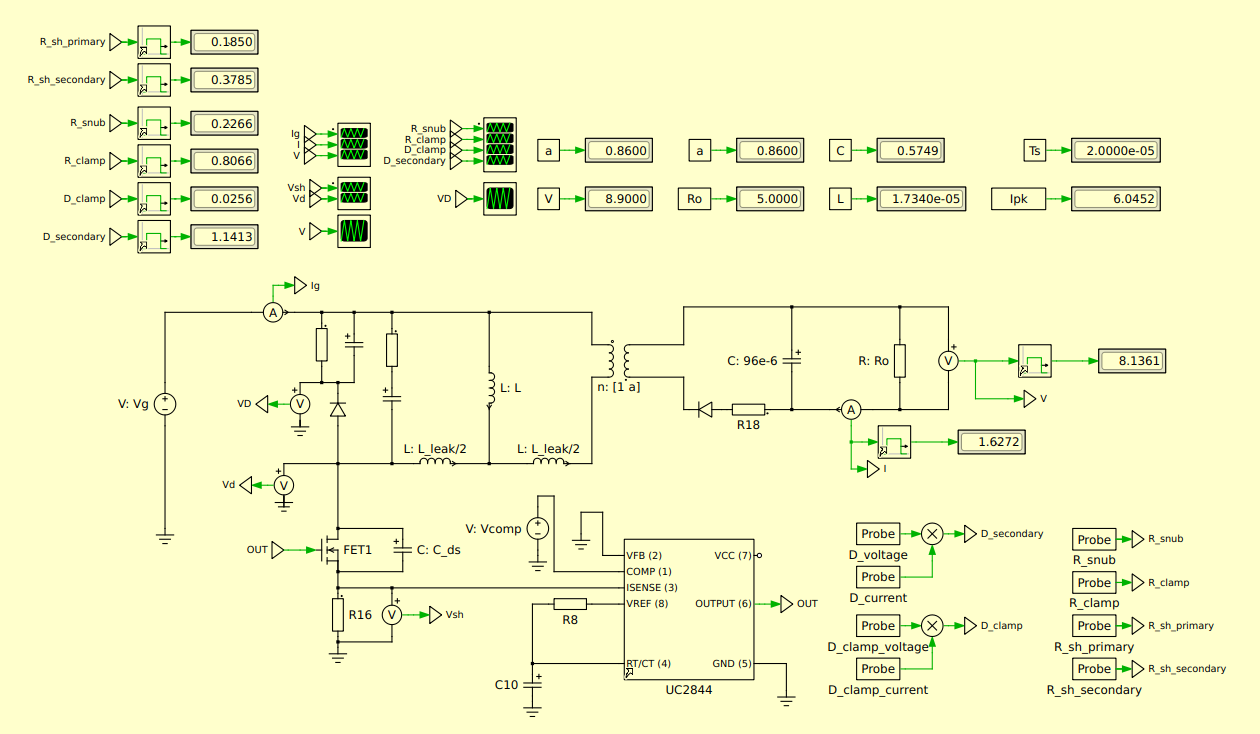

Q10: Create an updated pie chart.

In [5]:
# Update with actual duty cycle & ipk
R_DSON = 0.03 * units.ohm
D = 0.291 # Duty cycle
ipk = 0.28 * 20 * units.amp
irms = np.sqrt(D/3) * ipk

P_SC_CD = ipk**2 * R_DSON
print(f"The conduction losses from the semiconductor are about {P_SC_CD.to('watt')}.")

The conduction losses from the semiconductor are about 0.9408000000000002 W.


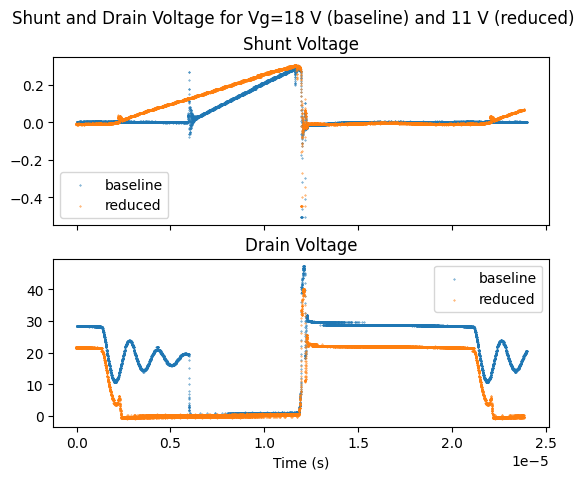

In [6]:
plot_vsh_vdr(["baseline", "reduced"], [[0,-1], [1550, 13500]], -0.315e-5)

MOSFET Switching Losses (Vg = 18V): 1.0475775466666635 W


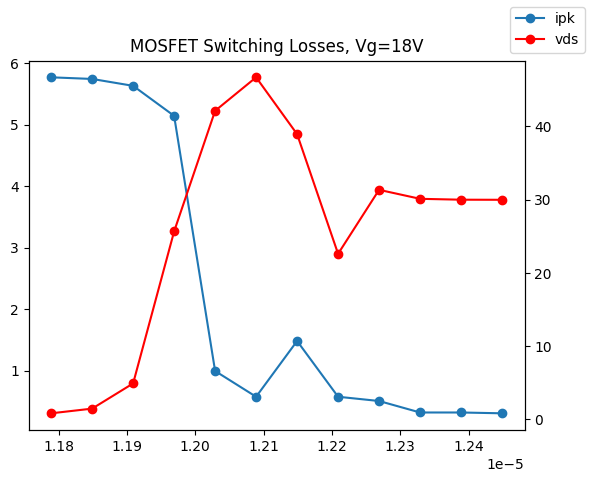

In [7]:
data = pd.read_csv("../data/baseline.csv")
increment = float(data["Increment"][0])
data = data.iloc[1: , :]
data = data.astype(float)

time = data["X"].to_numpy() * increment
ipk = data["CH1"].to_numpy() * 20
vds = data["CH2"].to_numpy()

n_bins = 400 # choose how many samples to use 
bin_size = (max(time) - min(time))/n_bins
time_res, vds_res, ipk_res = [],[], []
# Resample the data with consistent density 
for i in range(n_bins-1): 
    lower = time >= min(time)+i*bin_size
    higher = time < min(time)+(i+1)*bin_size
    time_res.append(np.mean(time[np.where(lower & higher)]))
    vds_res.append(np.mean(vds[np.where(lower & higher)]))
    ipk_res.append(np.mean(np.abs(ipk[np.where(lower & higher)])))

start_tick = int(n_bins * 0.49) 
end_tick = int(n_bins * 0.52)

p = np.multiply(ipk, vds)
p_res = np.multiply(ipk_res[start_tick:end_tick], vds_res[start_tick:end_tick])
e = np.trapz(p, time)
e_res = np.trapz(p_res, time_res[start_tick:end_tick]) * units.joule


fig, ax = plt.subplots()  
twinax = ax.twinx()
ax.plot(time_res[start_tick:end_tick], ipk_res[start_tick:end_tick], '-o', label='ipk')
twinax.plot(time_res[start_tick:end_tick], vds_res[start_tick:end_tick], 'r-o', label='vds')
fig.legend()
ax.set_title("MOSFET Switching Losses, Vg=18V")

fs = 50e3 / units.second
Ts = 1/fs
P_SC_SW = e_res / Ts
print("MOSFET Switching Losses (Vg = 18V):", P_SC_SW.to('watt'))

In [8]:
# Recalculate transformer conduction losses
R = 1.724e-8 * units.ohm / units.meter
mean_turn_length = 33 * units.mm
a = 0.731

n_primary = 8
n_secondary = 7
irms_primary = irms
irms_secondary = irms / a

loss_primary = (irms_primary**2 * R *  n_primary * mean_turn_length).to('watt').to_compact()
loss_secondary = (irms_secondary**2 * R * n_secondary * mean_turn_length).to('watt').to_compact()
P_TR_CD = loss_primary + loss_secondary

print(f"The transformer conduction loss is {P_TR_CD} with {loss_primary} being from the primary winding and {loss_secondary} being from the secondary.")


The transformer conduction loss is 36.51543445711391 nW with 13.844873011200002 nW being from the primary winding and 22.67056144591391 nW being from the secondary.


PLECS:
| Quantity        | Vg=18V |
|-----------------|--------|
| Primary Shunt   | 0.185  |
| Secondary Shunt | 0.379  |
| Snubber         | 0.227  |
| Clamp Resistor  | 0.807  |
| Clamp Diode     | 0.026  |
| Flyback Diode   | 1.141  |

Total Loss: 4.753377583182099 W


/home/lila/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3219: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x, np.float32)


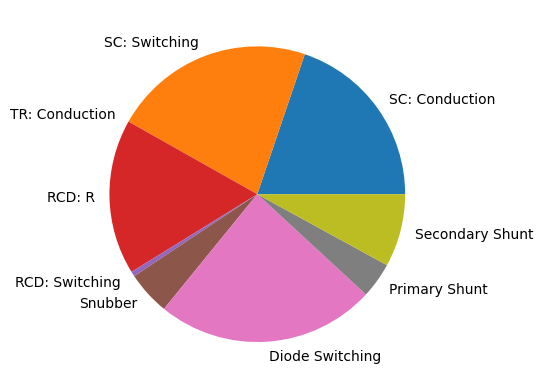

In [9]:
P_RC_SN = 0.227 * units.watt
P_RCD_R = 0.807 * units.watt
P_RCD_SW = 0.026 * units.watt
P_D_SW = 1.141 * units.watt
P_SH_P = 0.185 * units.watt
P_SH_S = 0.379 * units.watt


total = (P_SC_CD + P_SC_SW + P_TR_CD + P_RC_SN + P_RCD_R + P_RCD_SW + P_D_SW + P_SH_P + P_SH_S)
labels = 'SC: Conduction', 'SC: Switching', 'TR: Conduction', 'RCD: R', 'RCD: Switching', 'Snubber', 'Diode Switching', 'Primary Shunt', 'Secondary Shunt'
sizes = [P_SC_CD/total * 100,
         P_SC_SW/total * 100,
         P_TR_CD/total * 100,
         P_RCD_R/total * 100,
         P_RCD_SW/total * 100,
         P_RC_SN/total * 100,
         P_D_SW/total * 100,
         P_SH_P/total * 100,
         P_SH_S/total * 100]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)
print("Total Loss:", total.to('watt'))

While this pie chart reflects a total loss closer to our measured loss of 3.83 W than my prelab estimate of 5.34 W, it still is almost a watt higher than our measured value. This issue in part might be related to the data for calculating the semiconductor switching being rather noisy.

Q11: What is the trend in terms of total loss?

The loss percentage is slightly higher than our baseline as well as raw loss. However, in the reduced input voltage circuit, the output voltage is slightly lower due to constraints (0.4 V lower). Despite it being lower, our raw loss is still 3.86 W, higher than 3.83 W, indicating decreased efficiency at this operating point.

Q12: How would you expect the individual losses to change as the input voltage is reduced?

As the input voltage is reduced, you would expect to see the conduction losses increase as the duty cycle increases while ipk remains the same. We can calculate this using our new duty cycle: 47.8%:

In [10]:
# Update with actual duty cycle & ipk
R_DSON = 0.03 * units.ohm
D = 0.478 # Duty cycle
ipk = 0.30 * 20 * units.amp
irms = np.sqrt(D/3) * ipk

P_SC_CD_reduced = ipk**2 * R_DSON
print(f"The conduction losses at the reduced input voltage from the semiconductor are about {P_SC_CD.to('watt')}.")

The conduction losses at the reduced input voltage from the semiconductor are about 0.9408000000000002 W.


The losses from PLECS components add to the same quantity for both input voltages. 

| Quantity        | Vg=11V | Vg=18V |
|-----------------|--------|--------|
| Primary Shunt   | 0.301  | 0.185  |
| Secondary Shunt | 0.365  | 0.379  |
| Snubber         | 0.167  | 0.227  |
| Clamp Resistor  | 0.810  | 0.807  |
| Clamp Diode     | 0.026  | 0.026  |
| Flyback Diode   | 1.100  | 1.141  |
| **Total in PLECS**       | **2.769** | **2.765**  |

For an unknown reason, the switching losses from the MOSFET are very slightly higher at our higher input voltage, however, this in part may be due to noisy data. 

Q13: Does this give us any further information about the distribution of losses?

Our semiconductor conduction losses increased from 24.5% of losses to 28% of our losses when reducing voltage indicating that it is dependent on input voltage. The primary shunt resistor also doubled since the increased current-time results in more losses. The snubber had a slight decrease in loss: the voltage over the snubber was decreased with smaller peaks. 

MOSFET Switching Losses (Vg = 11V): 1.0241800960000238 W


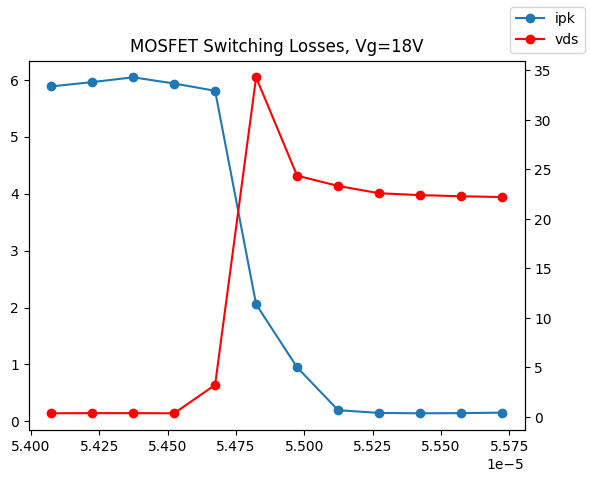

In [11]:
data = pd.read_csv("../data/reduced.csv")
increment = float(data["Increment"][0])
data = data.iloc[1: , :]
data = data.astype(float)

time = data["X"].to_numpy() * increment
ipk = data["CH1"].to_numpy() * 20
vds = data["CH2"].to_numpy()

n_bins = 400
bin_size = (max(time) - min(time))/n_bins
time_res, vds_res, ipk_res = [],[], []
# Resample the data with consistent density 
for i in range(n_bins-1): 
    lower = time >= min(time)+i*bin_size
    higher = time < min(time)+(i+1)*bin_size
    time_res.append(np.mean(time[np.where(lower & higher)]))
    vds_res.append(np.mean(vds[np.where(lower & higher)]))
    ipk_res.append(np.mean(np.abs(ipk[np.where(lower & higher)])))

start_tick = int(n_bins * 0.9) 
end_tick = int(n_bins * 0.93)

p = np.multiply(ipk, vds)
p_res = np.multiply(ipk_res[start_tick:end_tick], vds_res[start_tick:end_tick])
e = np.trapz(p, time)
e_res = np.trapz(p_res, time_res[start_tick:end_tick]) * units.joule


fig, ax = plt.subplots()  
twinax = ax.twinx()
ax.plot(time_res[start_tick:end_tick], ipk_res[start_tick:end_tick], '-o', label='ipk')
twinax.plot(time_res[start_tick:end_tick], vds_res[start_tick:end_tick], 'r-o', label='vds')
fig.legend()
ax.set_title("MOSFET Switching Losses, Vg=18V")

fs = 50e3 / units.second
Ts = 1/fs
P_SC_SW = e_res / Ts
print("MOSFET Switching Losses (Vg = 11V):", P_SC_SW.to('watt'))

Q14: 

One way we could improve the efficiency would be to use synchronous rectification rather than our diode, a component currently accounting for 24% of our losses. Synchronous rectification would elimate the diode drop to allow for a lower voltage drop. Finding a way to increase the clamp resistance while maintaining our filtering could also reduce the current through the clamp and decrease losses (currently, 21% of losses). The semiconductor conduction losses could decrease if we had a lower ipk or lower duty cycle, meaning we could switch to a lower a value for our turns ratio or increase our input voltage.